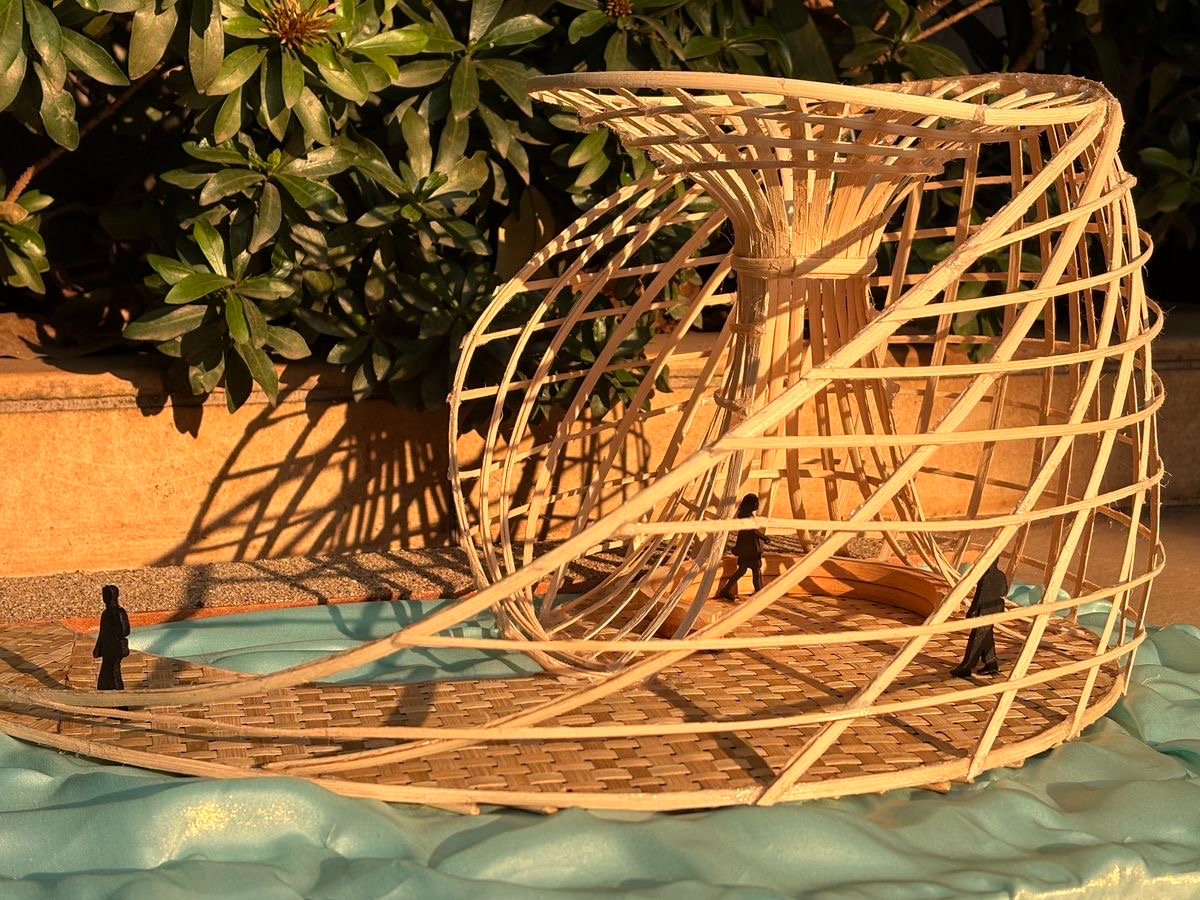

In [ ]:
"""
rattan_like_shell.py
產生一個中央收束柱 + 扭轉肋 (spiral ribs) 與環向圈 (hoops) 的參數化構型，
並在 matplotlib 3D 中繪製成線框視覺化。

使用方法：
    python rattan_like_shell.py

可調參數都在 'Config' 區塊調整。
"""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401 (required to enable 3d projection)

# -----------------------
# Config: 可調參數
# -----------------------
n_ribs = 20          # 肋的數量（從底部延伸並繞柱）
turns = 1.2          # 每肋繞柱的圈數（>1 會出現多圈）
points_per_rib = 400 # 每條肋的取樣點
height = 0.6         # 總高度（單位任意，視覺上調整）
base_radius = 1.2    # 底部大半徑
top_radius = 0.25    # 頂端收束半徑（收縮成柱）
twist = 2.5          # 扭轉程度（影響肋的旋轉速率）
radial_wave_amp = 0.08  # 半徑波動振幅（使肋不那麼規則）
radial_wave_freq = 6    # 半徑波動頻率
n_hoops = 6             # 環向圈（水平圈）的數量
hoop_points = 120       # 每個環的取樣點

# 畫面參數
line_width = 0.9
rib_color = (0.6, 0.45, 0.28)  # 棕色系 (r,g,b)
hoop_color = (0.55, 0.38, 0.25)
column_color = (0.45, 0.3, 0.2)

# -----------------------
# 幫助函式：profile 與座標映射
# -----------------------
def radius_profile(z):
    """
    給定高度 z (0..height)，回傳該高度處的橫向半徑（中間向上收縮）。
    這邊使用二次收縮：R(z) = top + (base-top) * (1 - (z/h)^2)
    你可以用其他函數改變外型（例如更尖、或平頂）。
    """
    t = np.clip(z / height, 0.0, 1.0)
    return top_radius + (base_radius - top_radius) * (1.0 - t**2)

def spiral_rib(angle_offset):
    """
    產生一條肋的 3D 座標陣列（x,y,z），angle_offset 決定肋起始角度。
    我們用參數 t 從 0 到 1 做對應：theta = 2π * turns * t
    z = height * t
    x = r(z) * cos(theta + angle_offset + twist * t)
    y = r(z) * sin(theta + angle_offset + twist * t)
    另外加上小振幅的半徑波動，模擬編織不規則感。
    """
    t = np.linspace(0.0, 1.0, points_per_rib)
    theta = 2.0 * np.pi * turns * t
    z = height * t

    # 基本半徑隨高度變化
    r = radius_profile(z)

    # 加上小波動（讓肋不是完全球面）
    r = r * (1.0 + radial_wave_amp * np.sin(radial_wave_freq * theta + angle_offset))

    # 額外加一個隨高度的扭轉相位（讓肋朝上更扭）
    phase = angle_offset + twist * t * 2.0 * np.pi

    x = r * np.cos(theta + phase)
    y = r * np.sin(theta + phase)

    return x, y, z

def hoop_ring(z_layer):
    """
    產生水平環（hoop）的座標：以該高度 z_layer 的 profile 半徑作為基準。
    """
    t = np.linspace(0.0, 2.0 * np.pi, hoop_points)
    r = radius_profile(z_layer)
    # 可以在環上也加入小波動以增加手感
    r = r * (1.0 + 0.02 * np.sin(3 * t + z_layer * 20.0))
    x = r * np.cos(t)
    y = r * np.sin(t)
    z = np.full_like(x, z_layer)
    return x, y, z

def central_column():
    """
    產生中央收束柱（縮小版的圓柱 / 花瓶狀）。
    我們在頂端附近用較小半徑
    """
    z = np.linspace(0.0, height, 120)
    # column radius 比 top_radius 還小一些以顯示收束
    col_r = np.interp(z, [0.0, height], [top_radius * 1.1, top_radius * 0.5])
    theta = np.linspace(0, 2*np.pi, 60)
    # 產生環狀點集合以利視覺化（繪多個圈）
    rings = []
    for zi, ri in zip(z[::6], col_r[::6]):
        t = np.linspace(0, 2*np.pi, 30)
        x = ri * np.cos(t)
        y = ri * np.sin(t)
        zz = np.full_like(x, zi)
        rings.append((x,y,zz))
    return rings

# -----------------------
# 繪圖
# -----------------------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 畫每一條肋
for i in range(n_ribs):
    offset = 2.0 * np.pi * i / n_ribs
    x, y, z = spiral_rib(offset)
    ax.plot(x, y, z, linewidth=line_width, color=rib_color, alpha=0.95)

# 畫水平環（hoops）
for k in range(n_hoops):
    z_layer = (k / (n_hoops - 1)) * height if n_hoops > 1 else height * 0.5
    xh, yh, zh = hoop_ring(z_layer)
    ax.plot(xh, yh, zh, linewidth=1.2, color=hoop_color, alpha=0.9)

# 畫中央收束柱的多個小圈
for (x,y,z) in central_column():
    ax.plot(x, y, z, linewidth=1.1, color=column_color, alpha=0.95)

# 調整視覺化範圍與樣式
max_range = base_radius * 1.5
ax.set_box_aspect((1, 1, height / max_range * 2.2))  # 設定長寬高比例，避免視覺被壓扁
ax.set_xlim(-max_range, max_range)
ax.set_ylim(-max_range, max_range)
ax.set_zlim(0.0, height * 1.05)

# 移除刻度、標籤（呈現模型草圖風格）
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.grid(False)

# 視角（可調）
ax.view_init(elev=20, azim=-40)

plt.title("Parametric Twisted Rib Shell (示意圖)")
plt.tight_layout()
plt.show()
